In [111]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from scipy.stats import linregress
import matplotlib as mpl
from statsmodels.api import tsa
import statsmodels.api as sm
import xarray as xr

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
# mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['font.size'] = 12

def get_forcing(saod):
    '''
    Takes in a timeseries of SAOD (numpy array) and outputs a forcing profile (in W/m^2)
    '''
    return np.multiply(-20.7, np.subtract(1, np.exp(np.multiply(-1, saod))))

def remove_volcano(timeseries, temp_anomaly):
    X = temp_anomaly # independent variable
    y = timeseries   # dependent variable

    # to get intercept -- this is optional
    X = sm.add_constant(X)

    # fit the regression model
    reg = sm.OLS(y, X).fit()
    
    return reg.resid.values

# take a spatial average
def weighted_mean(da):
    
    # make 2d array of weights in case that lat is 1d
    if len(da.lat.shape)==2:
        weights=np.cos(np.deg2rad(da.lat))
    elif len(da.lat.shape)==1:
        weights = xr.ones_like(da)* (np.cos(np.deg2rad((da.lat))).values)
    
    # turn weights into nan where da is nan
    weights = weights*da/da
    
    if 'lat' in da.dims:
        wm = (da*weights).sum(dim=['lat'], skipna=True) / weights.sum(dim=['lat'], skipna=True)
    elif 'i' in da.dims:
        wm = (da*weights).sum(dim=['i','j'], skipna=True) / weights.sum(dim=['i','j'], skipna=True)
    elif 'nlat' in da.dims:
        wm = (da*weights).sum(dim=['nlat','nlon'], skipna=True) / weights.sum(dim=['nlat','nlon'], skipna=True)
    elif 'x' in da.dims:
        wm = (da*weights).sum(dim=['x','y'], skipna=True) / weights.sum(dim=['x','y'], skipna=True)
    return wm

def compute_cox(x):
    x = x[~np.isnan(x)]
    psi_vals=[]
    for i in np.arange(0, len(x)-55):
        y = signal.detrend(x[i:i+55])
        auto_m1 = tsa.acf(y,nlags=1) # autocorrelation function from statsmodels
        auto_m1b = auto_m1[1]    # select 1 lag autocorrelation value
        sigma_m1= np.std(y)
        log_m1= np.log(auto_m1b)
        log_m1b = np.abs(log_m1)   # take absolute value
        sqrt_m1 = np.sqrt(log_m1b)
        psi = sigma_m1/sqrt_m1
        psi_vals.append(psi)
    return np.nanmean(psi_vals)

def compute_nijsse(x, length=10):
    # remove NaNs from the timeseries
    x = np.array(x)
    mask = ~np.isnan(x)
    x = x[mask]
    # fill it with slopes
    slopes = []
    i = 0
    while i < len(x)-length:
        slope, intercept, r, p, se = linregress(np.arange(0,length), x[i:i+length])
        slopes.append(length*slope)
        i+=length
    return np.nanstd(slopes)

In [118]:
evolv2k_ts = weighted_mean(xr.open_dataset('data/evolv2k.nc')).sel(time=slice(850,1850))
evolv2k_saod = []
i=850
while i <= 1850:
    evolv2k_saod.append(float(evolv2k_ts.sel(time=slice(i, i+1)).mean(dim='time').aod550.values))
    i+=1
evolv2k_forcing = get_forcing(evolv2k_saod)

gao_2008_saod = np.divide(pd.read_csv('data/gao_2008.csv')['gm'].values.astype(float), 1.2*10**3)
gao_2008_forcing = get_forcing(gao_2008_saod)

crowley_2000_forcing = pd.read_csv('data/crowley_2000.txt', delimiter = '\t')['Vol.hl.cct'].values

crowley_2008_saod = pd.read_csv('data/crowley_2008.txt', delimiter = '\t')['AOD'].values
crowley_2008_forcing = get_forcing(crowley_2008_saod)

In [129]:
df = pd.read_csv('data/ts.csv')
model_keys = df.keys()[2:]
forcings = ['gao', 'gao', 'crowley_08', 'crowley_00',
            'evolv2k', 'crowley_08', 'gao', 'evolv2k',
            'crowley_08', 'gao', 'evolv2k', 'gao', 
            'evolv2k', 'evolv2k', 'evolv2k', 'crowley_08',
            'evolv2k']
ecs_vals = []
original_cox = []
rv_cox = []
original_nijsse = []
rv_nijsse = []

t = pd.read_csv('data/ecs.csv')

df_rv = {}

for i in range(len(model_keys)):
    ts = df[model_keys[i]].values
    ts_historical = ts[1001:]
    ts_past1000 = ts[:1001]
    if model_keys[i] == 'HadCM3':
        X = crowley_2008_forcing
        y = ts_past1000
        X = sm.add_constant(X)
        reg = sm.OLS(y, X).fit()
        ecs_vals.append(t[t['model name']==model_keys[i]]['ecs'].values[0])
        original_cox.append(compute_cox(ts))
        rv_cox.append(compute_cox(np.append(np.add(reg.resid, reg.params[0]), ts_historical)))
        original_nijsse.append(compute_nijsse(ts))
        rv_nijsse.append(compute_nijsse(np.append(np.add(reg.resid, reg.params[0]), ts_historical)))
        df_rv[model_keys[i]] = np.append(np.add(reg.resid, reg.params[0]), ts_historical)
    elif forcings[i] == 'gao':
        X = gao_2008_forcing
        y = ts_past1000
        X = sm.add_constant(X)
        reg = sm.OLS(y, X).fit()
        ecs_vals.append(t[t['model name']==model_keys[i]]['ecs'].values[0])
        original_cox.append(compute_cox(ts))
        rv_cox.append(compute_cox(np.append(np.add(reg.resid, reg.params[0]), ts_historical)))
        original_nijsse.append(compute_nijsse(ts))
        rv_nijsse.append(compute_nijsse(np.append(np.add(reg.resid, reg.params[0]), ts_historical)))
        df_rv[model_keys[i]] = np.append(np.add(reg.resid, reg.params[0]), ts_historical)
    elif forcings[i] == 'crowley_00':
        X = crowley_2000_forcing
        y = ts[151:]
        X = sm.add_constant(X)
        reg = sm.OLS(y, X).fit()
        ecs_vals.append(t[t['model name']==model_keys[i]]['ecs'].values[0])
        original_cox.append(compute_cox(ts))
        rv_cox.append(compute_cox(np.add(reg.resid, reg.params[0])))
        original_nijsse.append(compute_nijsse(ts))
        rv_nijsse.append(compute_nijsse(np.add(reg.resid, reg.params[0])))
        df_rv[model_keys[i]] = np.append(ts[:151],np.add(reg.resid, reg.params[0]))
    elif forcings[i] == 'crowley_08':
        X = crowley_2008_forcing
        y = ts_past1000
        X = sm.add_constant(X)
        reg = sm.OLS(y, X).fit()
        ecs_vals.append(t[t['model name']==model_keys[i]]['ecs'].values[0])
        original_cox.append(compute_cox(ts))
        rv_cox.append(compute_cox(np.append(np.add(reg.resid, reg.params[0]), ts_historical)))
        original_nijsse.append(compute_nijsse(ts))
        rv_nijsse.append(compute_nijsse(np.append(np.add(reg.resid, reg.params[0]), ts_historical)))
        df_rv[model_keys[i]] = np.append(np.add(reg.resid, reg.params[0]), ts_historical)
    elif forcings[i] == 'evolv2k':
        X = evolv2k_forcing
        y = ts_past1000
        X = sm.add_constant(X)
        reg = sm.OLS(y, X).fit()
        ecs_vals.append(t[t['model name']==model_keys[i]]['ecs'].values[0])
        original_cox.append(compute_cox(ts))
        rv_cox.append(compute_cox(np.append(np.add(reg.resid, reg.params[0]), ts_historical)))
        original_nijsse.append(compute_nijsse(ts))
        rv_nijsse.append(compute_nijsse(np.append(np.add(reg.resid, reg.params[0]), ts_historical)))
        df_rv[model_keys[i]] = np.append(np.add(reg.resid, reg.params[0]), ts_historical)

/tmp/ipykernel_273933/803090135.py:65: RuntimeWarning: invalid value encountered in log
  log_m1= np.log(auto_m1b)


In [132]:
df = {'model': model_keys, 'generation': t['generation'].values, 'cox': original_cox, 'rv_cox': rv_cox, 'nijsse': original_nijsse, 'rv_nijsse': rv_nijsse, 'ecs': ecs_vals}
pd.DataFrame(df).to_csv('data/ec_data.csv')

In [133]:
pd.DataFrame(df_rv).to_csv('data/ts_rv.csv')

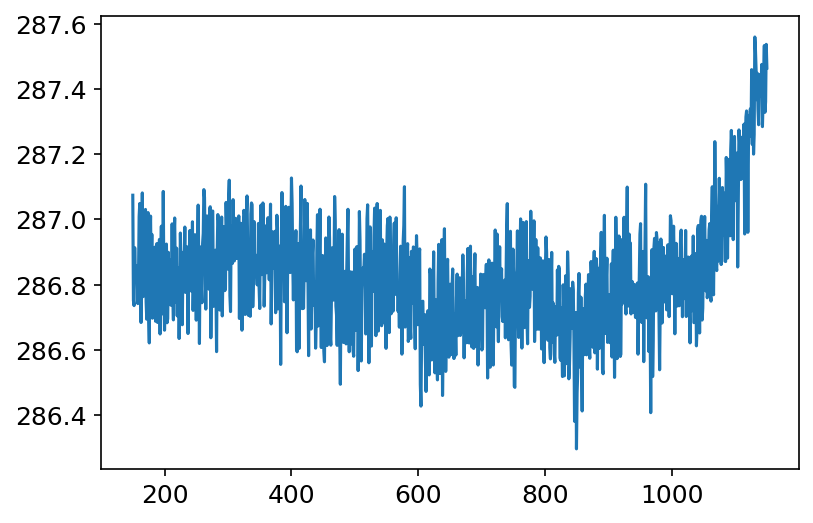

In [130]:
plt.plot(df_rv['FGOALS-gl'])